In [1]:
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration,AutoConfig, AutoModelForCausalLM
import transformer_lens
from PIL import Image,ImageOps
from tqdm import tqdm 
import os
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


<h3>Настройка модели</h3>
Для привязки HookedTransformer к языковой модели и onevision, используем всё тот же фикс конфига.

In [2]:
from lib_func_replace import get_pretrained_model_config_fixed

model_id = "llava-hf/llava-onevision-qwen2-0.5b-ov-hf"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    cache_dir = "/model/"
).to(torch.device("cpu"))
qwen_model = "Qwen/Qwen2-0.5B-Instruct"
lens_model = transformer_lens.HookedTransformer.from_pretrained(qwen_model,hf_model=model.language_model)
model.to(device)
lens_model.to(device)
processor = AutoProcessor.from_pretrained(model_id)
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is color? Answer single word."},
          {"type": "image"},
        ],
    },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

Loaded pretrained model Qwen/Qwen2-0.5B-Instruct into HookedTransformer
Moving model to device:  cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


<h1>О подходе Logit Lens</h1>
Logit Lens - это метод изучения внутренней работы большой языковой модели, он заключается в сохранении выходов промежуточных слоев для последующего изучения. С помощью этого подхода можно подтвердить теорию, что с каждым последующим слоем трансформера выходы сходятся к окончательному ответу, а сам финальный выход может быть получен намного раньше.
Сами предположения модели о следующем токене можно получить сравнивая эмбеддинги промежуточных слоев с весами слоя Embedding, или подключая финальный линейный слой.

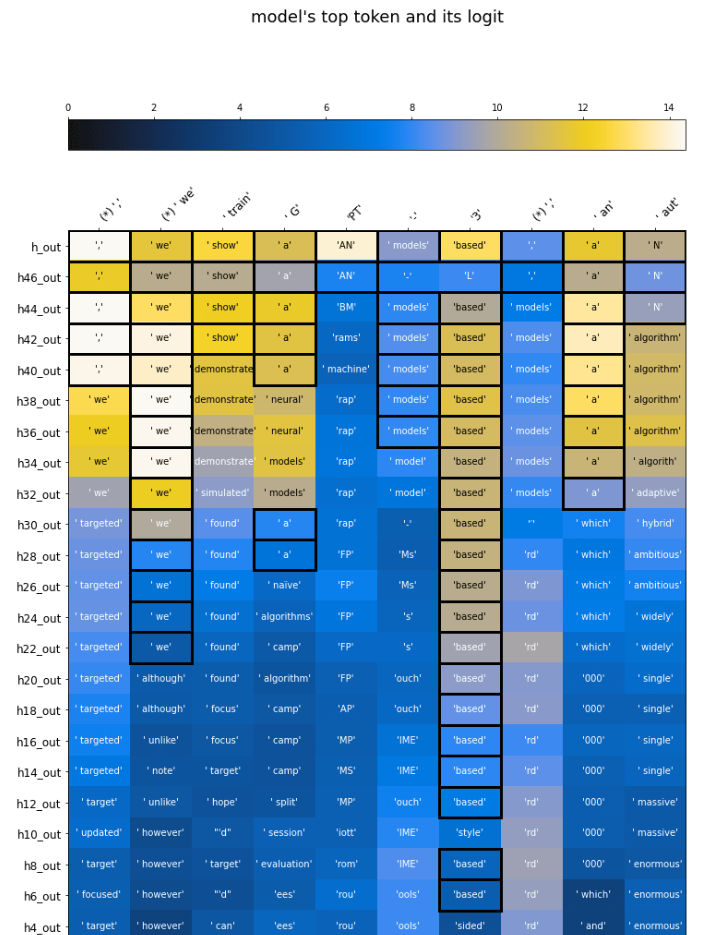

Изображение взято из статьи: https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens

<h3>Теперь с помощью transformerlens посмотрим, как языковая модель обрабатывает эмбеддинки из ViT.</h3>
Для этого надо будет вручную запускать ViT модель и обрабатывать её вывод. Код почти точно такой же, как в библиотечной реализации.

In [3]:
raw_image = Image.open("red plane.png").resize([384,384])

inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(torch.device("cuda"), torch.float16)
pixel_values = inputs.data["pixel_values"]
image_sizes = inputs.data["image_sizes"]
input_ids = inputs.data["input_ids"]
inputs_embeds = model.get_input_embeddings()(input_ids)



image_features = model.get_image_features(
                pixel_values,
                image_sizes,
                vision_feature_layer=model.config.vision_feature_layer,
                vision_feature_select_strategy=model.config.vision_feature_select_strategy,
            )
image_features, feature_lens = model.pack_image_features(
    image_features,
    image_sizes,
    image_newline=model.image_newline,
    vision_aspect_ratio=model.config.vision_aspect_ratio,
)
n_image_tokens = (input_ids == model.config.image_token_index).sum().item()
n_image_features = image_features.shape[0]

if n_image_tokens != n_image_features:
    raise ValueError(
        f"Image features and image tokens do not match: tokens: {n_image_tokens}, features {n_image_features}"
    )
special_image_mask = (
    (input_ids == model.config.image_token_index)
    .unsqueeze(-1)
    .expand_as(inputs_embeds)
    .to(inputs_embeds.device)
)
image_features = image_features.to(inputs_embeds.device, inputs_embeds.dtype)
inputs_embeds = inputs_embeds.masked_scatter(special_image_mask, image_features) # Данные для языковой модели

G:\ArcFacee\venv\lib\site-packages\transformers\models\siglip\modeling_siglip.py:574: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


К сожалению, run_with_cache из библиотеки transformerlens принимает на вход только токены, поскольку мы же имеем только эмбеддинки, и такая гибкость не предусмотрена в библиотеке, мы вынуждены снова заменить одну функцию у HookedTransformer, это сделано в отдельном файле fix_embeds
<h3>Теперь мы можем проверить, как языковая модель будет распознавать цвет сплошной заливки. Используется эта картинка.</h3>

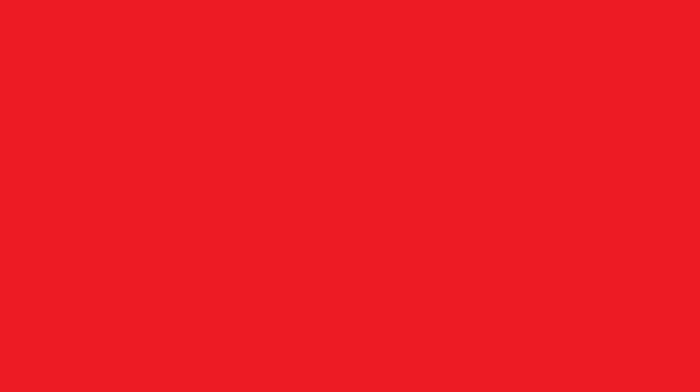

In [4]:
import fix_embeds # фикс

#Теперь можем запустить модель
logits, cache = lens_model.run_with_cache(inputs_embeds)

print("Ответ:")
print(processor.decode(logits[0][-1].argmax(0), skip_special_tokens=True))

Ответ:
Red


Теперь посмотрим как изменялись предположения модели с каждый слоем.

In [5]:
logits = cache.accumulated_resid()[:,0,-1].to(torch.float16)
llm_embeds = model.language_model.base_model.embed_tokens.weight

mul = torch.matmul(llm_embeds,logits.transpose(0,1))
ids = mul.argmax(dim=0)
for i in range(len(ids)):
    print("Layer",i,":", processor.tokenizer.decode(ids[i]))
del cache

Layer 0 : 

Layer 1 : 一定程度
Layer 2 : 拷
Layer 3 : 一定程度
Layer 4 : 迂
Layer 5 : 壮
Layer 6 : 渺
Layer 7 : 苛
Layer 8 : .getSelectionModel
Layer 9 :  
Layer 10 : .getSelectionModel
Layer 11 : 赤
Layer 12 : .getSelectionModel
Layer 13 : .getSelectionModel
Layer 14 : .getSelectionModel
Layer 15 : 惊
Layer 16 : .getSelectionModel
Layer 17 : 繁
Layer 18 : .getSelectionModel
Layer 19 : .getSelectionModel
Layer 20 : 迂
Layer 21 :  red
Layer 22 :  red
Layer 23 :  Red
Layer 24 : Red


Как видим, предположение о цвете формируется только на 21 слое, после 23 слоя уточняется место слова в предложении и делается вывод, что оно стоит первым, и его следует писать с большой буквы.

Так же можно посмотреть, как близка в финальному результату(Red) модель на промежуточных слоях:

In [6]:
mul = torch.matmul(llm_embeds,logits.transpose(0,1))
true = mul.argmax(dim=0)[-1]
val, ids = torch.sort(mul,dim=0,descending =True)
for i in range(25):
    print("Layer",i,":",ids[:,i].tolist().index(true)+1)

Layer 0 : 5170
Layer 1 : 1352
Layer 2 : 3433
Layer 3 : 9473
Layer 4 : 6967
Layer 5 : 3108
Layer 6 : 19423
Layer 7 : 2442
Layer 8 : 17409
Layer 9 : 15109
Layer 10 : 24018
Layer 11 : 21527
Layer 12 : 75406
Layer 13 : 55583
Layer 14 : 46951
Layer 15 : 19527
Layer 16 : 34476
Layer 17 : 8098
Layer 18 : 5809
Layer 19 : 941
Layer 20 : 199
Layer 21 : 16
Layer 22 : 4
Layer 23 : 3
Layer 24 : 1



<h1>Изучение "специализации" голов внимания</h1>
Есть предположение о том, что разные головы на одном слое "специализируются" либо на текстовом промте, или на фичах изображения, причем задачи каждой головы практически не пересекаются. Давайте проверим это утверждение на датасете фотографий цветков с помощью следующего кода.
Просуммируем скоры внимания для каждой головы на каждом слое. Скоры на эмбеддингах изображения записываем в одну переменную, скор на текст в другую.

In [7]:
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is the color of the flower? Answer single word."},
          {"type": "image"},
        ],
    },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

heads = {} # Будет содержаться информация о том куда обращается каждая голова
activation = [] # Будет содержаться информация о том куда обращается каждая голова

for i in range(24):
    for j in range(14):
        heads[(i,j)] = [0,0]

folder_path = "flowers/"
with torch.no_grad():
    for filename in tqdm(os.listdir(folder_path)[:25]):
        # Проверяем, является ли файл изображением (по расширению)
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Полный путь к изображению
            image_path = os.path.join(folder_path, filename)

            raw_image = Image.open(image_path).resize([384,384])

            inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(torch.device("cuda"), torch.float16)
            pixel_values = inputs.data["pixel_values"]
            image_sizes = inputs.data["image_sizes"]
            input_ids = inputs.data["input_ids"]
            inputs_embeds = model.get_input_embeddings()(input_ids)
            # print(processor.decode(input_ids[0], skip_special_tokens=False))

            image_features = model.get_image_features(
                pixel_values,
                image_sizes,
                vision_feature_layer=model.config.vision_feature_layer,
                vision_feature_select_strategy=model.config.vision_feature_select_strategy,
            )
            image_features, feature_lens = model.pack_image_features(
                image_features,
                image_sizes,
                image_newline=model.image_newline,
                vision_aspect_ratio=model.config.vision_aspect_ratio,
            )
            n_image_tokens = (input_ids == model.config.image_token_index).sum().item()
            n_image_features = image_features.shape[0]

            if n_image_tokens != n_image_features:
                raise ValueError(
                    f"Image features and image tokens do not match: tokens: {n_image_tokens}, features {n_image_features}"
                )
            special_image_mask = (
                (input_ids == model.config.image_token_index)
                    .unsqueeze(-1)
                    .expand_as(inputs_embeds)
                    .to(inputs_embeds.device)
            )
            image_features = image_features.to(inputs_embeds.device, inputs_embeds.dtype)
            inputs_embeds = inputs_embeds.masked_scatter(special_image_mask, image_features)

            logits, cache = lens_model.run_with_cache(inputs_embeds)
            #cache.to(torch.device("cpu"))
            lc = []

            for layer in range(24):
                attention_pattern = cache["pattern", layer, "attn"]
                for head in range(14):
                    scores = attention_pattern[0, head, -1]
                    heads[(layer, head)][0] += round((scores * special_image_mask[0, :, 0]).sum().item(), 2)
                    heads[(layer, head)][1] += round((scores * ~special_image_mask[0, :, 0]).sum().item(), 2)
                    lc.append(attention_pattern[0, head, -1])
            activation.append(torch.stack(lc))
            del cache

for i in range(24):
    for j in range(14):
        print("For",i,"layer",j,"head",round(heads[(i,j)][0],2),round(heads[(i,j)][1],2))

100%|██████████████████████████████████████████| 25/25 [00:56<00:00,  2.27s/it]

For 0 layer 0 head 1.0 24.0
For 0 layer 1 head 17.9 7.1
For 0 layer 2 head 0.65 24.35
For 0 layer 3 head 21.65 3.35
For 0 layer 4 head 3.68 21.32
For 0 layer 5 head 19.18 5.82
For 0 layer 6 head 0.23 24.77
For 0 layer 7 head 0.89 24.11
For 0 layer 8 head 17.3 7.7
For 0 layer 9 head 10.74 14.26
For 0 layer 10 head 3.69 21.31
For 0 layer 11 head 19.3 5.7
For 0 layer 12 head 25.0 0.0
For 0 layer 13 head 0.09 24.91
For 1 layer 0 head 3.23 21.77
For 1 layer 1 head 2.52 22.48
For 1 layer 2 head 1.17 23.83
For 1 layer 3 head 16.1 8.9
For 1 layer 4 head 8.55 16.45
For 1 layer 5 head 5.39 19.61
For 1 layer 6 head 11.21 13.79
For 1 layer 7 head 0.38 24.62
For 1 layer 8 head 4.54 20.46
For 1 layer 9 head 0.74 24.26
For 1 layer 10 head 0.28 24.72
For 1 layer 11 head 0.56 24.44
For 1 layer 12 head 11.63 13.37
For 1 layer 13 head 12.24 12.76
For 2 layer 0 head 0.44 24.56
For 2 layer 1 head 6.59 18.41
For 2 layer 2 head 6.95 18.05
For 2 layer 3 head 2.54 22.46
For 2 layer 4 head 0.83 24.17
For 2 laye

Первое число после слова "head" указывает на сумму скоров на токены изображения, второе число - на токены текста.
<h3>Вывод</h3>
Таким образом, большая разница между двумя этими числами символизирует что большинство голов внимания ориентируются на что-то одно, либо на изображение, либо на текст, причём чем выше слой, тем меньше голов смотрит на изображение (возможно потому, что визуальная информация распространилась и по токенам, которые были изначально текстовыми), за исключением последних двух слоев, которые возможно уточняют описание. (Так же этот код был запущен на разных датасетах с разными промтами, результат тот же).

Согласно статье о изучении внутренней работы MultiLLM (MMNeuron: Discovering Neuron-Level Domain-Specific Interpretation in Multimodal Large Language Model https://aclanthology.org/2024.emnlp-main.387.pdf пункт 4.2.1) во время работы LLM можно выделить 3 стадии:
1) дополнительно выравнивание эмбеддингов изображения,
2) изучение признаков
3) генерация ответа на запрос

Из изучения работы голов внимания можно сделать похожий вывод и выделить 3 стадии. В отличии от нашего подхода, авторы этой статьи изучали распределение количества специальных нейронов, которые активируются для различных видов изображений. 

<h3>Наблюдение</h3>
Те головы, которые смотрят на изображение имеют очень разреженные скоры внимания, то есть такие головы как будто смотрят одновременно на все токены изображения. Например голова 11 слоя 0:

In [8]:
#Максимальное значения скора внимания
activation[0][11,10:1450].max()


tensor(0.0087, device='cuda:0')

То что почти все головы на более высоких слоях смотрят на текстовые токены можно попробовать объяснить тем, что вся необходимая визуальная информация хранилась в бывших текстовых токенах, так и тем, что процесс моделирования языка является значительно более сложным, чем обработка визуальных признаков.

Так же стоит отметить такую особенность модели, что если её уже подается на вход изображение 384x384, то происходит двойная обработка этой картинки из за специфики работы подхода AnyRes, которое не только разбивает изображение с высоким разрешением на чанки по 384х384, но и добавляет сжатую копию целого изображения как один из чанков.

В вышеупомянутой статье проводилось исследование зависимости активации нейронов в слоях разных глубин при обработке изображений разных видов (например, медицина или документы) с помощью Activation Probability Entropy. В ней был сделан вывод, что в зависимости от концептуальной сложности изображений, будут сильнее активироваться нейроны на более глубоких слоях. 
По сравнению с logit lens, подход, используемый в статье, может дать более подробную информацию о работе модели, т.к. в нем изучается не только выходы промежуточных слоев, но и отдельные нейроны в MLP секции слоя трансформера. 